Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 3.037413583875505e-05


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 3.550048281470568e-05


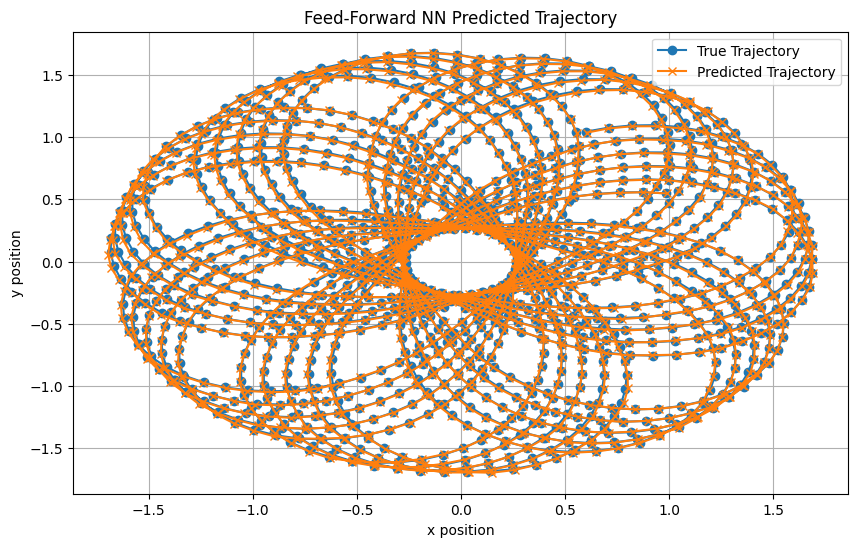

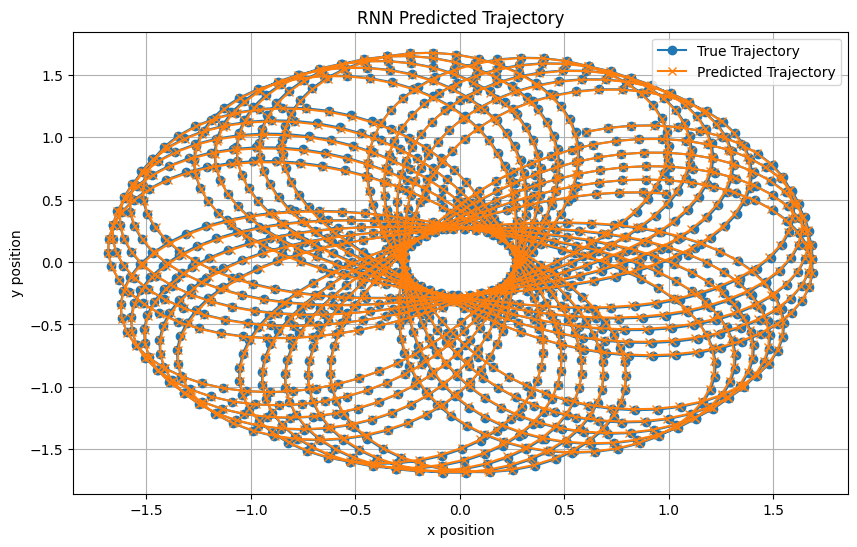

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model

batch_size = 64
num_epochs = 200


def load_data(file_path):
    data = np.loadtxt(file_path)
    velocities = data[:, :2]
    positions = data[:, 2:]
    return velocities, positions

train_velocities, train_positions = load_data('data_lorentz/train.txt')
test_velocities, test_positions = load_data('data_lorentz/test.txt')

# Create input-output pairs for training
def create_pairs(velocities, positions):
    input_states = np.hstack((velocities[:-1], positions[:-1]))
    output_states = np.hstack((velocities[1:], positions[1:]))
    return input_states, output_states

train_input_states, train_output_states = create_pairs(train_velocities, train_positions)
test_input_states, test_output_states = create_pairs(test_velocities, test_positions)

# Convert data to PyTorch tensors
train_input_states = torch.tensor(train_input_states, dtype=torch.float32)
train_output_states = torch.tensor(train_output_states, dtype=torch.float32)
test_input_states = torch.tensor(test_input_states, dtype=torch.float32)
test_output_states = torch.tensor(test_output_states, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(train_input_states, train_output_states)
test_dataset = torch.utils.data.TensorDataset(test_input_states, test_output_states)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader, criterion)

# Instantiate the RNN model, define loss function and optimizer
rnn_model = RecurrentNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

train_model(rnn_model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(rnn_model, test_loader, criterion)

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, input_states, true_positions, title):
    model.eval()
    with torch.no_grad():
        predicted_states = model(input_states).numpy()
    
    predicted_positions = predicted_states[:, 2:]  # Extract predicted positions
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare input data for plotting predicted trajectories
test_input_states_np = test_input_states.numpy()
test_output_positions_np = test_output_states[:, 2:].numpy()

# Plot predicted trajectories for feed-forward neural network
plot_predicted_trajectories(model, test_input_states, test_output_positions_np, 'Feed-Forward NN Predicted Trajectory')

# Plot predicted trajectories for recurrent neural network
plot_predicted_trajectories(rnn_model, test_input_states, test_output_positions_np, 'RNN Predicted Trajectory')
